In [1]:
import sys
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import mdtraj as md
from scipy import stats

blocking_dir='/projects/prism/people/hzr104/software/BLOCKING_OLD/MonoCV'
sys.path.append(blocking_dir)
import block


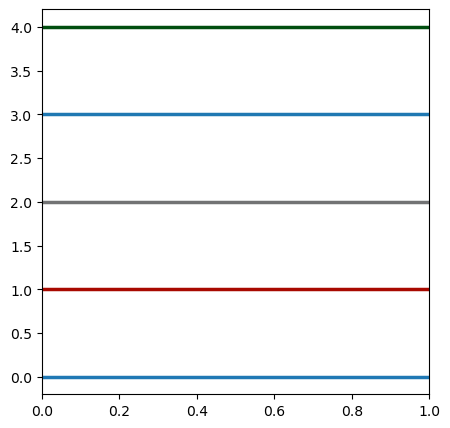

In [2]:
from matplotlib.colors import LinearSegmentedColormap

#new_cmap = [ '#1F78B4', '#E31A1C', '#8660AF', '#FF7F50', '#17A589', '#AF7AC5']
new_cmap= ['#1f78b4', '#A80900', '#737373', '#1f78b4', '#004e0f'] 

rtg_r = LinearSegmentedColormap.from_list("rtg", new_cmap)
colors = rtg_r(np.linspace(0,1,5))

#Test colormap
fig = plt.figure(figsize=(5,5))

for i,color in enumerate(colors):
    plt.axhline(i, color=colors[i], linewidth=2.5)

In [3]:
theta_sel = 13
traj = '../trajectory_CG/prodrun_joinedreplicas.xtc'
top = '../trajectory_CG/PRO_CG.gro'

errmethod = 'hline' #for blocking

DBD_atoms = np.arange(325, 504) #138GLU-209ARG (inclusive)
LBD_atoms = np.arange(556, 1187) #234PRO-505TYR (inclusive)


In [4]:
#Loads SAXS intensities calculated from simulations - in BME format
def load_sim_SAXS(calc_file):
    calc_data = np.array([[float(x) for x in line.split()[1:]] for line in open(calc_file) if("#" not in line)])
    return np.array(calc_data)

#Loads experimental SAXS q, I and err - in BME format
def load_exp_SAXS(exp_file):
    q, I, err = np.genfromtxt(exp_file, usecols=(0,1,2), skip_header=0, unpack=True)
    return np.array(q), np.array(I), np.array(err)

def get_chi2(Iaverage_sim, I_exp, err_exp):
    
    chi2 = np.average(np.square((Iaverage_sim-I_exp)/err_exp))
    
    return chi2

#Fit calc data profiles scale and offset with linear regression
def fit_scale_offset(Iaverage_sim, I_exp, err_exp):
    #Get weight for each point based on exp error
    sample_weight=1.0/(err_exp**2)
    
    #Linear regression
    reg = LinearRegression(fit_intercept=True).fit(Iaverage_sim.reshape(-1,1),I_exp.reshape(-1,1),sample_weight=sample_weight)
    r_value = reg.score(Iaverage_sim.reshape(-1,1),I_exp.reshape(-1,1),sample_weight=sample_weight)
    slope,intercept = reg.coef_[0],reg.intercept_
    
    Iaverage_sim_fit = Iaverage_sim*slope+intercept
    
    return Iaverage_sim_fit, slope, intercept, r_value

def save_pickle(filename, pickle_obj):
    with open(filename, 'wb') as f:
        pkl.dump(pickle_obj, f)

def load_pickle(filename):
    with open(filename, 'rb') as f:
        loaded_obj = pkl.load(f)
        
    return loaded_obj

def block_err_analysis(CV, errmethod):
    ##Block error anaylsis
    
    #Trim Rg array for block error analysis
    CV = block.check(CV, multi=1)

    #Block error analysis
    blocks_stat = block.blocking(CV)

    #Choose optimal block size and find error
    if errmethod=='b3':
        corr_len, err = block.optimal_block(len(CV),blocks_stat,method="b3")
    elif errmethod=='knee_loc':
        corr_len, err = block.optimal_block(len(CV),blocks_stat,method="knee_loc",S=2.7)
    elif errmethod=='hline':
        corr_len, err = block.optimal_block(len(CV),blocks_stat,method="hline")
        
    return corr_len, err, blocks_stat


# BME theta scan

<>:13: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\c'
<>:13: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2894506/497422830.py:13: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel('$\phi_{eff}$', fontsize=20)
/tmp/ipykernel_2894506/497422830.py:14: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel('$\chi^2_r$', fontsize=20)


545.5594781168514 0.36484670759274523 1.2136235107115059


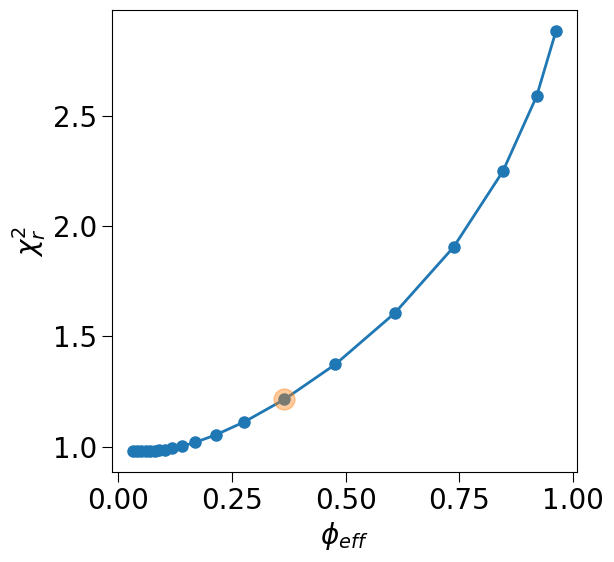

In [5]:
reweighting_results = load_pickle('../6_reweighting_dAB/reweighting_dAB.pkl')

fig = plt.figure(figsize=(6,6))
#Δ
#plt.title('$\Delta$AB SAXS', fontsize=20)
plt.plot(reweighting_results['phi'], reweighting_results['chi2'], 'o-', lw=2, ms=8)

theta_sel_val = reweighting_results['theta'][theta_sel]
print(theta_sel_val, reweighting_results['phi'][theta_sel], reweighting_results['chi2'][theta_sel])
plt.plot(reweighting_results['phi'][theta_sel], reweighting_results['chi2'][theta_sel], 'o', ms=15, alpha=0.4, label=f'{theta_sel_val}')

#plt.legend(fontsize=20)
plt.xlabel('$\phi_{eff}$', fontsize=20)
plt.ylabel('$\chi^2_r$', fontsize=20)
plt.tick_params(colors='black', direction='out', length=7, labelsize=20)

fig.savefig(f"../figures/dAB_rew/chi2_vs_phieff.pdf", bbox_inches='tight', pad_inches=1, dpi=400)

save_pickle('../6_reweighting_dAB/weights.pkl', np.array(reweighting_results['weights'][theta_sel]))

# SAXS

In [6]:
SAXS = load_sim_SAXS(f'../6_reweighting_dAB/calc_SAXS_dAB.dat')
weights = load_pickle(f'../6_reweighting_dAB/weights.pkl')

SAXS_avg = np.average(SAXS, axis=0)
SAXS_avg_rew = np.average(SAXS, axis=0, weights=weights)

3.59674468723677 1.2136214000904877


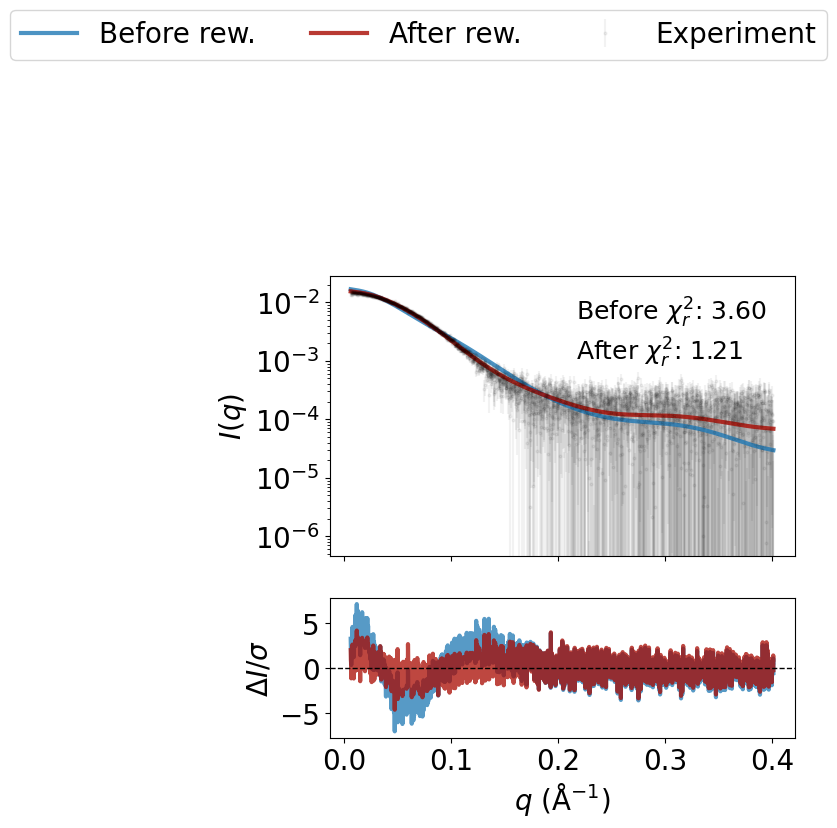

In [7]:
q, I_exp, err_exp = load_exp_SAXS(f'../6_reweighting_dAB/PPARg_dAB_SAXSexpt.dat')
q *= 0.1

SAXS_avg_scaleoffset, slope, intercept, r_value = fit_scale_offset(SAXS_avg, I_exp, err_exp)
SAXS_avg_rew_scaleoffset, slope, intercept, r_value = fit_scale_offset(SAXS_avg_rew, I_exp, err_exp)

chi2 = get_chi2(SAXS_avg_scaleoffset, I_exp, err_exp)
chi2_rew = get_chi2(SAXS_avg_rew_scaleoffset, I_exp, err_exp)
print(chi2, chi2_rew)

residuals = (SAXS_avg_scaleoffset-I_exp)/err_exp
residuals_rew = (SAXS_avg_rew_scaleoffset-I_exp)/err_exp

#SAXS figure
fig, ax = plt.subplots(figsize = (6,6), nrows=2, sharex='col', sharey='row', gridspec_kw={'height_ratios': [4, 2]})

#ax[0].set_title('$\Delta$AB SAXS', fontsize=30)

ax[0].errorbar(q, I_exp, yerr=err_exp, fmt='o', markersize=2, color='black', alpha=0.05, label='Experiment')
ax[0].plot(q, SAXS_avg_scaleoffset, linewidth=3, label="Before rew.", alpha=0.8, color=colors[0])
ax[0].plot(q, SAXS_avg_rew_scaleoffset, linewidth=3, label="After rew.", alpha=0.8, color=colors[1])

ax[0].semilogy()
ax[0].set_ylabel('$I(q)$', fontsize=20)
ax[0].legend(fontsize=20, ncol=6, bbox_to_anchor=(1.1, 2.0))
ax[0].text(0.53,0.70, f'Before $χ^2_r$: {chi2:.2f} \nAfter $χ^2_r$: {chi2_rew:.2f}', fontsize=18, transform=ax[0].transAxes)

for j in range(len(ax)):
    ax[j].tick_params(axis='both', which='major', labelsize=20)

ax[1].plot(q, residuals, linewidth=3, color= colors[0], alpha=0.75)
ax[1].plot(q, residuals_rew, linewidth=3, color= colors[1], alpha=0.75)

ax[1].set_ylabel('$ΔI/σ$', fontsize=20)
ax[1].set_xlabel('$q$ (Å$^{-1}$)', fontsize=20)
ax[1].axhline(0, ls='--', linewidth=1, color='black')

fig.savefig(f"../figures/dAB_rew/SAXS.pdf", bbox_inches='tight', pad_inches=1, dpi=400)

# DBD-LBD COMdist

Removing 1 at the bottom of each replica
Possible blocks transformations: 8

Removing 2 at the bottom of each replica
Possible blocks transformations: 40



/projects/prism/people/hzr104/software/BLOCKING_OLD/MonoCV/block.py:59: RuntimeWarning: invalid value encountered in scalar divide
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


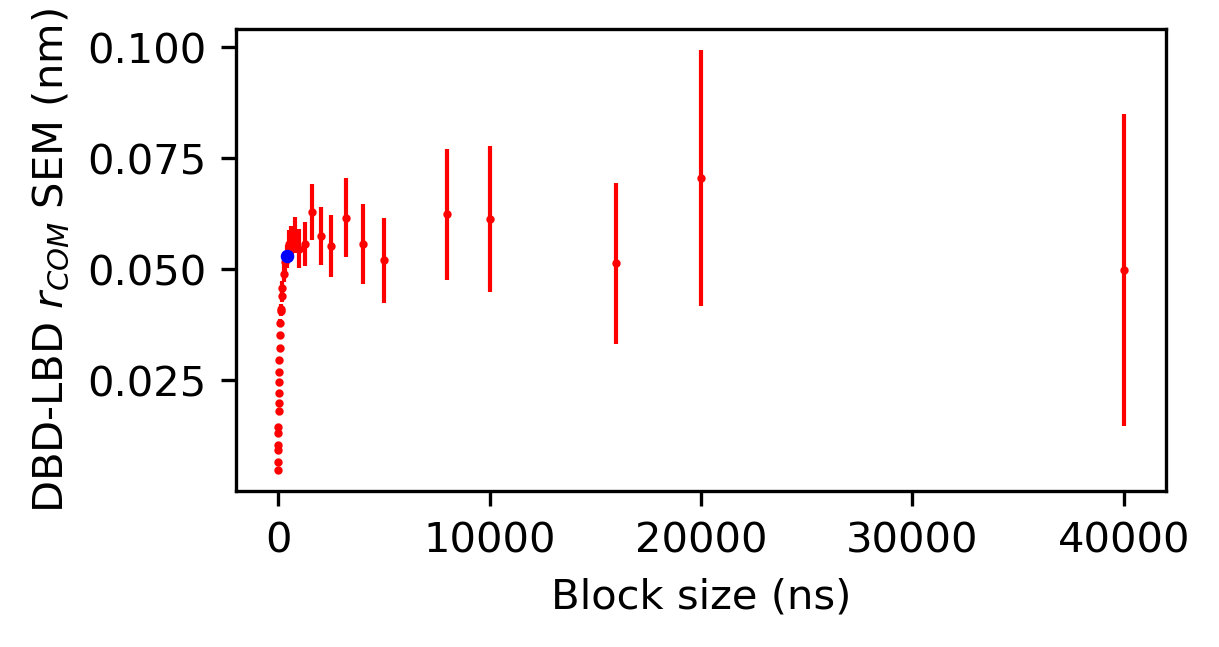

In [8]:
mdtraj = md.load(traj, top=top)

DBD_slice = mdtraj.atom_slice(DBD_atoms)
LBD_slice = mdtraj.atom_slice(LBD_atoms)

DBD_COM = md.compute_center_of_mass(DBD_slice)
LBD_COM = md.compute_center_of_mass(LBD_slice)

DBD_LDB_COMdist = np.linalg.norm(DBD_COM-LBD_COM, axis=1)

#Block error analysis
corr_len, err, blocks_stat = block_err_analysis(DBD_LDB_COMdist, errmethod)
plt.fig = plt.figure(figsize=(4, 2), dpi=300, facecolor='w')
plt.xlabel('Block size (ns)')
plt.ylabel('DBD-LBD $r_{COM}$ SEM (nm)')
plt.errorbar(blocks_stat[...,0],blocks_stat[...,1],blocks_stat[...,2],fmt='ro',ms=1,elinewidth=1)
plt.scatter(corr_len,err,c='blue',zorder=300,s=5)


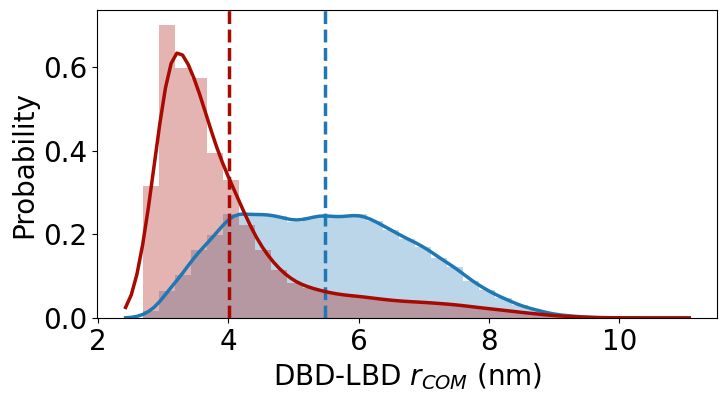

In [9]:
fig = plt.figure(figsize=(8,4))

#KDE
kde_x = np.linspace( np.amin(DBD_LDB_COMdist)*0.9, np.amax(DBD_LDB_COMdist)*1.1, num = 100 )
kde_y = stats.gaussian_kde(DBD_LDB_COMdist, bw_method = "silverman").evaluate(kde_x)

plt.hist(DBD_LDB_COMdist, density=True, color=colors[0], alpha=0.3, bins=30)
plt.plot(kde_x, kde_y, '-', linewidth=2.5, color=colors[0], label='Before rew.')

plt.axvline(x=np.average(DBD_LDB_COMdist), ls='--', linewidth=2.5, alpha=1, color=colors[0])

weights = load_pickle(f'../6_reweighting_dAB/weights.pkl')

#KDE
kde_x = np.linspace( np.amin(DBD_LDB_COMdist)*0.9, np.amax(DBD_LDB_COMdist)*1.1, num = 100 )
kde_y = stats.gaussian_kde(DBD_LDB_COMdist, bw_method = "silverman", weights=weights).evaluate(kde_x)

plt.hist(DBD_LDB_COMdist, weights=weights, density=True, color=colors[1], alpha=0.3, bins=30)
plt.plot(kde_x, kde_y, '-', linewidth=2.5, color=colors[1], label='After rew.')

plt.axvline(x=np.average(DBD_LDB_COMdist, weights=weights), ls='--', linewidth=2.5, alpha=1, color=colors[1])

#plt.title('Reweighting against $\Delta$AB SAXS', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('DBD-LBD $r_{COM}$ (nm)', fontsize=20)
plt.ylabel('Probability', fontsize=20)

fig.savefig(f"../figures/dAB_rew/DBD_LBD_COMdist_histogram.pdf", bbox_inches='tight', pad_inches=1, dpi=400)

# Rg

Removing 1 at the bottom of each replica
Possible blocks transformations: 8

Removing 2 at the bottom of each replica
Possible blocks transformations: 40



/projects/prism/people/hzr104/software/BLOCKING_OLD/MonoCV/block.py:59: RuntimeWarning: invalid value encountered in scalar divide
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


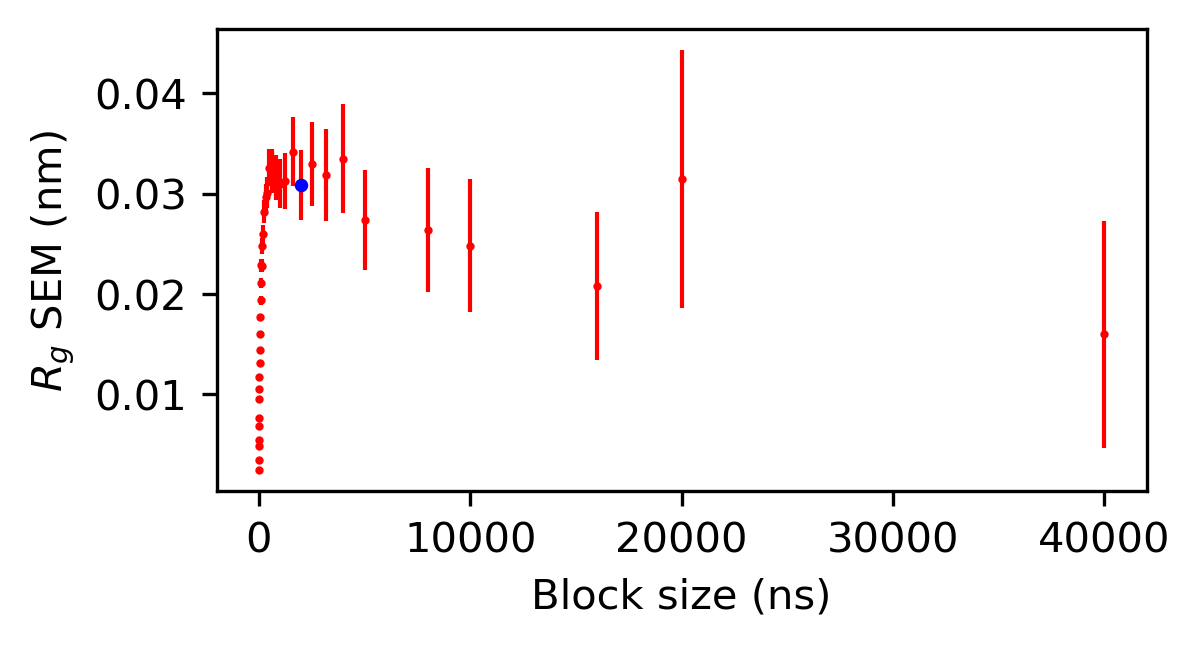

In [10]:
time, Rg1 = np.genfromtxt(f'../5_analyze_traj/calc_Rg/Rg_gyrate_free_rep1.xvg', usecols=(0,1), skip_header=27, unpack=True)
time, Rg2 = np.genfromtxt(f'../5_analyze_traj/calc_Rg/Rg_gyrate_free_rep2.xvg', usecols=(0,1), skip_header=27, unpack=True)

Rg = [*Rg1, *Rg2]

#Block error analysis
corr_len, err, blocks_stat = block_err_analysis(Rg, errmethod)
plt.fig = plt.figure(figsize=(4, 2), dpi=300, facecolor='w')
plt.xlabel('Block size (ns)')
plt.ylabel('$R_g$ SEM (nm)')
plt.errorbar(blocks_stat[...,0],blocks_stat[...,1],blocks_stat[...,2],fmt='ro',ms=1,elinewidth=1)
plt.scatter(corr_len,err,c='blue',zorder=300,s=5)


<>:23: SyntaxWarning: invalid escape sequence '\D'
<>:23: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_2894506/2563025486.py:23: SyntaxWarning: invalid escape sequence '\D'
  plt.title('Reweighting against $\Delta$AB SAXS', fontsize=25)


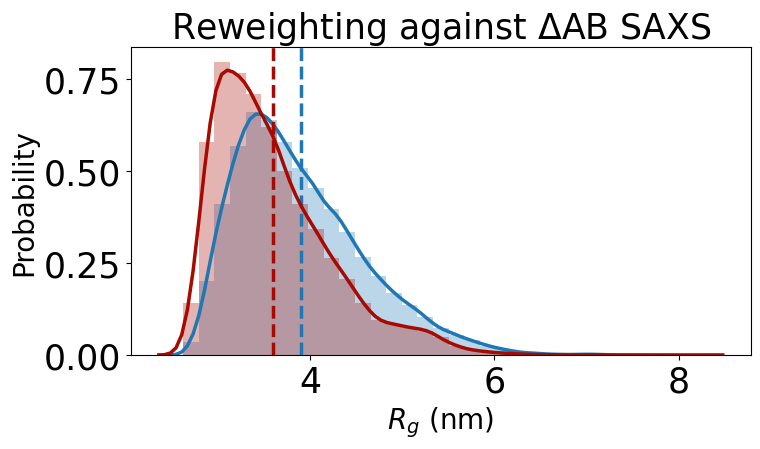

In [11]:
fig = plt.figure(figsize=(8,4))

#KDE
kde_x = np.linspace( np.amin(Rg)*0.9, np.amax(Rg)*1.1, num = 100 )
kde_y = stats.gaussian_kde(Rg, bw_method = "silverman").evaluate(kde_x)

plt.hist(Rg, density=True, color=colors[0], alpha=0.3, bins=30)
plt.plot(kde_x, kde_y, '-', linewidth=2.5, color=colors[0], label='Before rew.')

plt.axvline(x=np.average(Rg), ls='--', linewidth=2.5, alpha=1, color=colors[0])

weights = load_pickle(f'../6_reweighting_dAB/weights.pkl')

#KDE
kde_x = np.linspace( np.amin(Rg)*0.9, np.amax(Rg)*1.1, num = 100 )
kde_y = stats.gaussian_kde(Rg, bw_method = "silverman", weights=weights).evaluate(kde_x)

plt.hist(Rg, weights=weights, density=True, color=colors[1], alpha=0.3, bins=30)
plt.plot(kde_x, kde_y, '-', linewidth=2.5, color=colors[1], label='After rew.')

plt.axvline(x=np.average(Rg, weights=weights), ls='--', linewidth=2.5, alpha=1, color=colors[1])

plt.title('Reweighting against $\Delta$AB SAXS', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=25)

plt.xlabel('$R_g$ (nm)', fontsize=20)
plt.ylabel('Probability', fontsize=20)

fig.savefig(f"../figures/dAB_rew/Rg_histogram.pdf", bbox_inches='tight', pad_inches=1, dpi=400)

# Rg IDR only

Removing 1 at the bottom of each replica
Possible blocks transformations: 8

Removing 2 at the bottom of each replica
Possible blocks transformations: 40



/projects/prism/people/hzr104/software/BLOCKING_OLD/MonoCV/block.py:59: RuntimeWarning: invalid value encountered in scalar divide
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


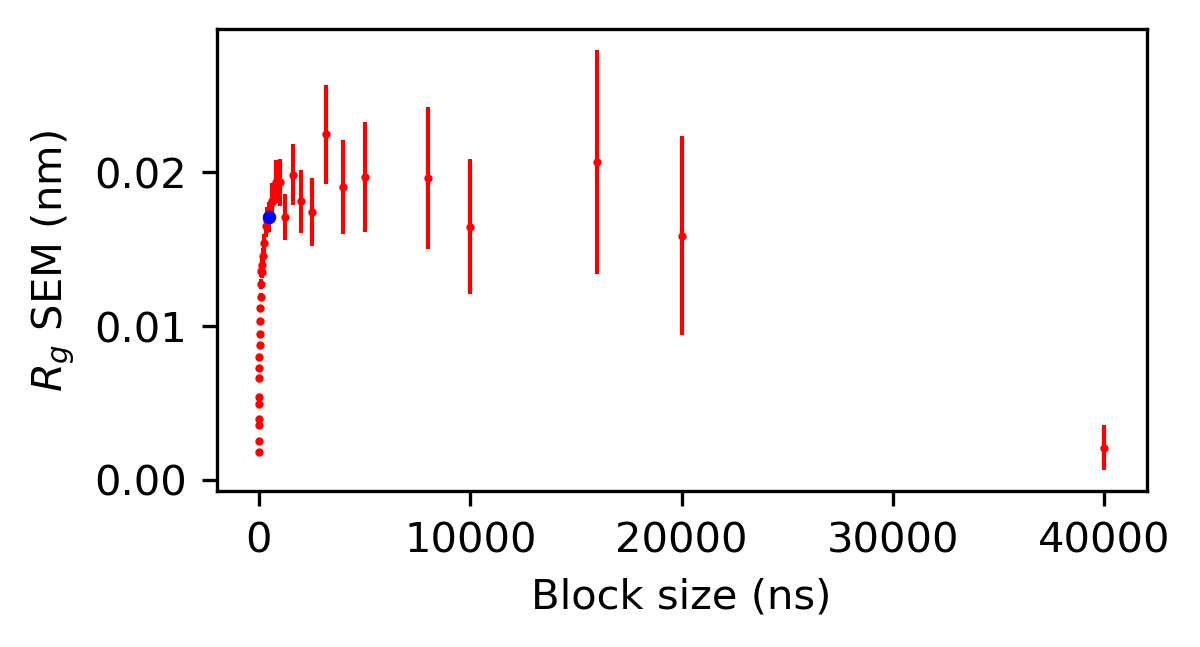

In [12]:
time, Rg1 = np.genfromtxt(f'../5_analyze_traj/calc_Rg/Rg_gyrate_IDRonly_free_rep1.xvg', usecols=(0,1), skip_header=27, unpack=True)
time, Rg2 = np.genfromtxt(f'../5_analyze_traj/calc_Rg/Rg_gyrate_IDRonly_free_rep2.xvg', usecols=(0,1), skip_header=27, unpack=True)

Rg = [*Rg1, *Rg2]

#Block error analysis
corr_len, err, blocks_stat = block_err_analysis(Rg, errmethod)
plt.fig = plt.figure(figsize=(4, 2), dpi=300, facecolor='w')
plt.xlabel('Block size (ns)')
plt.ylabel('$R_g$ SEM (nm)')
plt.errorbar(blocks_stat[...,0],blocks_stat[...,1],blocks_stat[...,2],fmt='ro',ms=1,elinewidth=1)
plt.scatter(corr_len,err,c='blue',zorder=300,s=5)


<>:23: SyntaxWarning: invalid escape sequence '\D'
<>:23: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_2894506/1374565972.py:23: SyntaxWarning: invalid escape sequence '\D'
  plt.title('Reweighting against $\Delta$AB SAXS', fontsize=25)


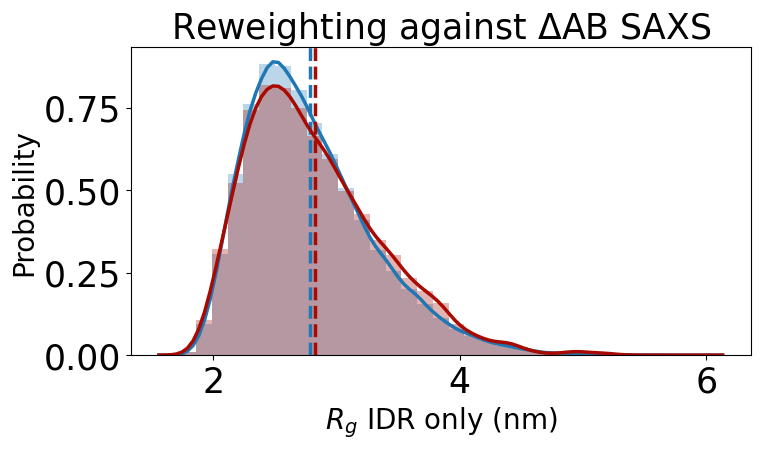

In [13]:
fig = plt.figure(figsize=(8,4))

#KDE
kde_x = np.linspace( np.amin(Rg)*0.9, np.amax(Rg)*1.1, num = 100 )
kde_y = stats.gaussian_kde(Rg, bw_method = "silverman").evaluate(kde_x)

plt.hist(Rg, density=True, color=colors[0], alpha=0.3, bins=30)
plt.plot(kde_x, kde_y, '-', linewidth=2.5, color=colors[0], label='Before rew.')

plt.axvline(x=np.average(Rg), ls='--', linewidth=2.5, alpha=1, color=colors[0])

weights = load_pickle(f'../6_reweighting_dAB/weights.pkl')

#KDE
kde_x = np.linspace( np.amin(Rg)*0.9, np.amax(Rg)*1.1, num = 100 )
kde_y = stats.gaussian_kde(Rg, bw_method = "silverman", weights=weights).evaluate(kde_x)

plt.hist(Rg, weights=weights, density=True, color=colors[1], alpha=0.3, bins=30)
plt.plot(kde_x, kde_y, '-', linewidth=2.5, color=colors[1], label='After rew.')

plt.axvline(x=np.average(Rg, weights=weights), ls='--', linewidth=2.5, alpha=1, color=colors[1])

plt.title('Reweighting against $\Delta$AB SAXS', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=25)

plt.xlabel('$R_g$ IDR only (nm)', fontsize=20)
plt.ylabel('Probability', fontsize=20)

fig.savefig(f"../figures/dAB_rew/Rg_IDRonly_histogram.pdf", bbox_inches='tight', pad_inches=1, dpi=400)